# Reversal Analysis

This notebook describes the procedure followed to analyze different aspects on the reversal of the trades

## Data collected

These are the variables collected for this work:

* End of trend
* RSI= Relative Strength Index (30 oversold / 70 overbought)
* Divergence (TRUE/FALSE)
* Number of bounces=Number of bounces in oversold/overbought 
* previous the reversal considering the entire trend in order to calculate bounces
* Trend length before (bars)
* Currency Pair
* Trend= Type of market. Possible values are up,down,ranging
* Continuation= Continuation trade. TRUE/FALSE
* Entry Time-frame
* Reversed=TRUE/FALSE
* Trend length after (bars)
* Ranging=TRUE/FALSE

I will adress the following questions:

* Relationship between outcome and Number of bounces
* Relationship between trend length before the reversal, RSI and outcome (possible ranging)
* What are the different values when ranging

## Load the dependencies

In [866]:
import pandas as pd
import numpy as np

%matplotlib inline

## Creating a dataframe with the data

In [867]:
DF = pd.read_csv("/Users/ernesto/Downloads/backtesting.csv",sep=',',index_col=False)

Total number of records is {{DF.shape[0]}}

## Select the records depending on the type of market
I will create 3 different dataframes depending on the type of market for a particular trade. I will consider 3 different types of market:

* Trending (upwards,downwards)
* Continuation
* Ranging

### Trending
First, we select from the initial dataframe the trades that are in a trending market

In [868]:
trending_DF=DF.loc[(DF['Trend']=='up') | (DF['Trend']=='down') & (DF['Continuation']==False)]

The total number of records is {{trending_DF.shape[0]}}

#### Divergence

##### Relationship between Reversed and Divergence

In this section, I will explore if the fact that there is divergence increase the propability of a reversal when the market is trending
First, we calculate counts:

In [869]:
div_class=pd.crosstab(index=trending_DF['Divergence'], columns=trending_DF['Reversed'],margins=True)

div_class.columns = ["Reversed_N","Reversed_Y","Rowtotal"]
div_class.index= ["Divergence_N","Divergence_Y","Coltotal"]

print(div_class)

              Reversed_N  Reversed_Y  Rowtotal
Divergence_N          11          35        46
Divergence_Y           2          22        24
Coltotal              13          57        70


And then, we calculate the proportion along each column:

In [870]:
prop=div_class/div_class.loc["Coltotal"]
print(prop)

              Reversed_N  Reversed_Y  Rowtotal
Divergence_N    0.846154    0.614035  0.657143
Divergence_Y    0.153846    0.385965  0.342857
Coltotal        1.000000    1.000000  1.000000


**Conclusion:**
{{'%.2f' % prop.iloc[0, 0]}} of trades not reversing did not present RSI divergence and {{'%.2f' % prop.iloc[1, 0]}} presented RSI divergence.
So RSI divergence is a good predictor of price reversal

##### Relationship between 'Trend length after (bars)' and 'Divergence'

In this section, I will explore the relationship between the presence of Divergence and the length (in number of candles) of the trend after the reversal.

Firstly, we select the records that reversed:

In [871]:
reversed_true=trending_DF.loc[trending_DF['Reversed']==True]

And now, we compare the average length of the trend after the reversal in records having RSI divergence and not having RSI divergence

In [872]:
avg_trendafter=reversed_true.groupby(['Divergence']).agg({'Trend length after (bars)': 'mean'})

print(avg_trendafter)

            Trend length after (bars)
Divergence                           
False                       42.371429
True                        91.545455


**Conclusion:** On average and if the market is trending, the number of candles for the trend after the reversal in trades presenting divergence is {{'%.0f' % avg_trendafter.iloc[1, 0]}} and the average number for trades not presenting divergence is {{'%.0f' % avg_trendafter.iloc[0, 0]}}

##### Relationship between 'Trend length before(bars)' and 'Divergence'

In this section, I will explore the relationship between the presence of Divergence and the length (in number of candles) of the trend before the reversal. This will give an idea on the correlation between the length of the trend pre-reversal and the appearance of divergence

In [873]:
avg_trendbefore=reversed_true.groupby(['Divergence']).agg({'Trend length before(bars)': 'mean'})

print(avg_trendbefore)

            Trend length before(bars)
Divergence                           
False                       48.057143
True                        81.227273


**Conclusion:** On average and if the market is trending, the number of candles for the trend before the reversal in trades presenting divergence is {{'%.0f' % avg_trendbefore.iloc[1, 0]}} and the average number for trades not presenting divergence is {{'%.0f' % avg_trendbefore.iloc[0, 0]}}

##### Relationship between 'Number of bounces' and 'Divergence'

In this section, I will address the correlation between the number of times the price has been in oversold/overbought RSI regions before the reversal happening when there is divergence compared to when there is no divergence

In [874]:
avg_nbounces=trending_DF.groupby(['Divergence']).agg({'Number of bounces': 'mean'})

print(avg_nbounces)

            Number of bounces
Divergence                   
False                1.065217
True                 3.000000


**Conclusion:** 
* On average, the trades **NOT** presenting divergence have {{'%.1f' % avg_nbounces.iloc[0, 0]}} times that the price has been  in oversold/overbought RSI regions
* On average, the trades presenting divergence have {{'%.1f' % avg_nbounces.iloc[1, 0]}} times that the price has been  in oversold/overbought RSI regions

##### What is the average RSI for divergent trades?:

In [875]:
divergent_true=trending_DF.loc[trending_DF['Divergence']==True]

divergent_true.groupby(['Trend']).agg({'RSI': 'mean'})

,RSI
Trend,
down,33.388235
up,64.571429


**Conclusion:**
The data collected indicates that it is not necessary to have the reversal in the oversold/overbought area in order to have a RSI divergence

#### No divergence
In this section, I am going to examine the trending trades that did not present divergence and are not continuation trades. First, we select the trending trades without divergence

In [876]:
non_div=trending_DF.loc[(trending_DF['Divergence']==False) & (trending_DF['Reversed']==True) & (trending_DF['Continuation']==False)]

There was a total of {{non_div.shape[0]}} trending trades with non divergence

##### What is the distribution of trend length values after the reversal?

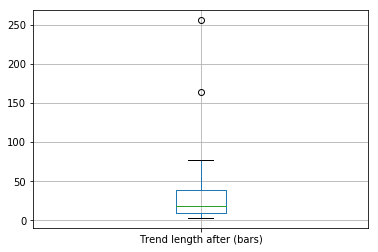

In [877]:
non_div[['Trend length after (bars)']].boxplot()

##### Categorizing the trend length after the reversal 
Now, we will bin `Trend length after (bars)` into discrete categories by using `pd.cut` and we will calculate the mean for each category using the following variables:
* Number of bounces
* Trend length before (bars)
* RSI

The cuts used with `pd.cut` are:

In [878]:
cuts=np.array([0,10,20,30,40,50,75,300])

 **Number of bounces**

In [879]:
print(non_div.groupby(pd.cut(non_div["Trend length after (bars)"], cuts)).agg({'Number of bounces': 'mean'}))

                           Number of bounces
Trend length after (bars)                   
(0, 10]                             1.700000
(10, 20]                            2.000000
(20, 30]                            2.666667
(30, 40]                            1.500000
(40, 50]                            0.000000
(50, 75]                            0.000000
(75, 300]                           0.000000


**Conclusion:** There could be a relationship between the length after trend the lower and the number of times that the RSI value has been in oversold/overbought-->More data is needed

**Trend length before (bars)**

In [880]:
print(non_div.groupby(pd.cut(non_div["Trend length after (bars)"], cuts)).agg({"Trend length before(bars)": 'mean'}))

                           Trend length before(bars)
Trend length after (bars)                           
(0, 10]                                    68.800000
(10, 20]                                   33.500000
(20, 30]                                   71.666667
(30, 40]                                   54.000000
(40, 50]                                   13.000000
(50, 75]                                   17.000000
(75, 300]                                  99.000000


**Conclusion:** It seems that there is no correlation between the length of the trade before and after the reversal

**RSI**<br>
First, let's divide depending on the value of Trend

In [881]:
up_df=non_div.loc[non_div['Trend']=='up']
down_df=non_div.loc[non_div['Trend']=='down']

There are {{up_df.shape[0]}} up trades
There are {{down_df.shape[0]}} down trades

Now, we categorize on the values of `Trend length after (bars)`:

In [882]:
print(up_df.groupby(pd.cut(up_df["Trend length after (bars)"], cuts)).agg({"RSI": 'mean'}))

                                 RSI
Trend length after (bars)           
(0, 10]                    67.500000
(10, 20]                   72.000000
(20, 30]                   71.000000
(30, 40]                   76.666667
(40, 50]                   77.000000
(50, 75]                   67.000000
(75, 300]                  73.000000


In [883]:
print(down_df.groupby(pd.cut(down_df["Trend length after (bars)"], cuts)).agg({"RSI": 'mean'}))

                                 RSI
Trend length after (bars)           
(0, 10]                    25.333333
(10, 20]                   24.000000
(20, 30]                   24.500000
(30, 40]                   23.000000
(40, 50]                         NaN
(50, 75]                         NaN
(75, 300]                  24.500000


**Conclusion:** There is no correlation between the `Trend length after (bars)` and RSI value

### Continuation
Now, let's select the trades considered as continuation trades:

In [884]:
cont_DF=DF.loc[DF['Continuation']==True]

There are {{cont_DF.shape[0]}} continuation trades

#### How many reversed=TRUE trades?
Out of all continuation trades, how many of them were successful

In [885]:
cont_rev=cont_DF.groupby(['Reversed']).size()
print(cont_rev)

Reversed
False     1
True     15
dtype: int64


**Conclusion:** There was {{'%.0f' % cont_rev.iloc[0]}} non reversing trade out of a {{cont_DF.shape[0]}} total continuation trades. So trades that are of continuation type have a great probability of being successful

##### What is the average RSI for continuation trades

In [886]:
cont_DF.groupby(['Trend']).agg({'RSI': 'mean'})

,RSI
Trend,
down,47.833333
up,46.600000


**Conclusion:**
The data collected indicates that the continuation trades do not have the reversal in the oversold/overbought area

### Ranging

Let's select now the ranging trades.

In [887]:
ranging_DF=DF.loc[(DF['Trend']=='ranging')]

There were {{ranging_DF.shape[0]}} ranging trades

#### How many reversed=TRUE trades?
Out of all ranging trades, how many of them were successful

In [891]:
ranging_DF.groupby(['Reversed']).size()
print(ranging_rev)

Reversed
False     6
True     17
dtype: int64


##### What is the average RSI for ranging reversed trades

First, we select the reversed trades and we calculate the mean RSI per group:

In [899]:
ranging_true=ranging_DF.loc[ranging_DF['Reversed']==True]
ranging_true.groupby(['Trend']).agg({'RSI': 'mean'})

,RSI
Trend,
ranging,48.941176


## General Conclusions

This is the list of the main conclusions derived from this work:

* Divergence can be used for predicting reversal
* The longer the before reversal trend the higher the probability of having divergence
* The higher the number of bounces the higher the probability of having divergence
* If there is divergence then it is more likely that the length of the after reversal increases
* In order to have a reversal and when there is divergence the RSI value does not need to be in the oversold/overbought area
* In order to have a reversal and when there is continuation the RSI value does not need to be in the oversold/overbought area and the average RSI values are (down~49/up~47)
* In order to have a reversal and when there is ranging the RSI value does not need to be in the oversold/overbought area